In [ ]:
# Save as week3_clean_data.npz for Week 3 to use
save_dict = {}
for i in range(1, 9):
    save_dict[f'inputs_{i}'] = inputs[i]
    save_dict[f'outputs_{i}'] = outputs[i]

np.savez('week3_clean_data.npz', **save_dict)
print("\n✓ Data saved as week3_clean_data.npz")
print("Week 3 notebook can now load this file directly!")

In [ ]:
# TODO: Update with actual Week 2 results when you receive them
week2_results = {
    1: 0.0,  # Replace with actual output for Function 1
    2: 0.0,
    3: 0.0,
    4: 0.0,
    5: 0.0,
    6: 0.0,
    7: 0.0,
    8: 0.0
}

# Add Week 2 results to current data
for i in range(1, 9):
    week2_input_reshaped = week2_recommendations[i].reshape(1, -1)
    inputs[i] = np.vstack([inputs[i], week2_input_reshaped])
    outputs[i] = np.append(outputs[i], week2_results[i])

print("Week 2 results added!")
print("\nUpdated data summary:")
for i in range(1, 9):
    print(f"  Function {i}: {inputs[i].shape[0]} points, best = {np.max(outputs[i]):.6f}")

# Week 2 - Bayesian Optimization

This notebook generates optimized recommendations for Week 2 using Gaussian Process regression and acquisition functions.

In [27]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

## 1. Load Initial Data

In [28]:
# Load initial data (before Week 1)
inputs = {}
outputs = {}

base = "../initial_data"

for i in range(1, 9):
    folder = f"{base}/function_{i}"
    inputs[i] = np.load(f"{folder}/initial_inputs.npy")
    outputs[i] = np.load(f"{folder}/initial_outputs.npy")

print("Initial data loaded:")
for i in range(1, 9):
    print(f"  Function {i}: {inputs[i].shape[0]} points, {inputs[i].shape[1]}D")

Initial data loaded:
  Function 1: 10 points, 2D
  Function 2: 10 points, 2D
  Function 3: 15 points, 3D
  Function 4: 30 points, 4D
  Function 5: 20 points, 4D
  Function 6: 20 points, 5D
  Function 7: 30 points, 6D
  Function 8: 40 points, 8D


## 2. Add Week 1 Results

In [29]:
# Week 1 submitted points and their outputs
week1_inputs = {
    1: np.array([0.4, 0.4]),
    2: np.array([0.72, 0.90]),
    3: np.array([0.51, 0.63, 0.32]),
    4: np.array([0.60, 0.45, 0.41, 0.27]),
    5: np.array([0.24, 0.83, 0.90, 0.90]),
    6: np.array([0.75, 0.17, 0.71, 0.67, 0.08]),
    7: np.array([0.08, 0.47, 0.27, 0.24, 0.44, 0.76]),
    8: np.array([0.07, 0.08, 0.04, 0.06, 0.42, 0.82, 0.51, 0.88])
}

week1_outputs = {
    1: 0.09787028091182691,
    2: 0.5567314070917742,
    3: -0.05929363571874033,
    4: -4.416289141043837,
    5: 1231.606836011881,
    6: -0.5919788840023106,
    7: 1.364636869415445,
    8: 9.58626
}

# Combine initial data with Week 1 results
for i in range(1, 9):
    week1_input_reshaped = week1_inputs[i].reshape(1, -1)
    inputs[i] = np.vstack([inputs[i], week1_input_reshaped])
    outputs[i] = np.append(outputs[i], week1_outputs[i])

print("\nCombined data (initial + Week 1):")
for i in range(1, 9):
    print(f"  Function {i}: {inputs[i].shape[0]} points total")


Combined data (initial + Week 1):
  Function 1: 11 points total
  Function 2: 11 points total
  Function 3: 16 points total
  Function 4: 31 points total
  Function 5: 21 points total
  Function 6: 21 points total
  Function 7: 31 points total
  Function 8: 41 points total


## 3. Bayesian Optimization Functions

In [30]:
def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Expected Improvement acquisition function
    Higher xi = more exploration
    """
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(Y_sample)
    sigma = sigma.reshape(-1, 1)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def upper_confidence_bound(X, X_sample, Y_sample, gp, kappa=2.0):
    """
    Upper Confidence Bound acquisition function
    Higher kappa = more exploration
    """
    mu, sigma = gp.predict(X, return_std=True)
    return mu + kappa * sigma


def propose_next_point(X_sample, Y_sample, bounds, acq_func='EI', xi=0.01, kappa=2.0, n_restarts=25):
    """
    Proposes the next sampling point using Bayesian Optimization
    
    Args:
        X_sample: Observed inputs (n_samples, n_dims)
        Y_sample: Observed outputs (n_samples,)
        bounds: Bounds for each dimension [(min, max), ...]
        acq_func: 'EI' (Expected Improvement) or 'UCB' (Upper Confidence Bound)
        xi: Exploration parameter for EI
        kappa: Exploration parameter for UCB
        n_restarts: Number of random restarts for optimization
    
    Returns:
        next_point: Suggested next point to sample
        gp: Fitted Gaussian Process model
    """
    dim = X_sample.shape[1]
    
    # Fit Gaussian Process
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(dim), nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
    gp.fit(X_sample, Y_sample)
    
    # Optimize acquisition function
    min_val = 1e10
    min_x = None
    
    def min_obj(X):
        X = X.reshape(-1, dim)
        if acq_func == 'EI':
            return -expected_improvement(X, X_sample, Y_sample, gp, xi).flatten()
        else:
            return -upper_confidence_bound(X, X_sample, Y_sample, gp, kappa).flatten()
    
    # Multiple random restarts
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun[0] if isinstance(res.fun, np.ndarray) else res.fun
            min_x = res.x
    
    return min_x, gp

print("Bayesian Optimization functions defined!")

Bayesian Optimization functions defined!


## 4. Generate Week 2 Recommendations

In [31]:
print("=" * 70)
print("WEEK 2 BAYESIAN OPTIMIZATION RECOMMENDATIONS")
print("=" * 70)

week2_recommendations = {}

for func_id in range(1, 9):
    X = inputs[func_id]
    y = outputs[func_id]
    dim = X.shape[1]
    
    # Bounds: all inputs are in [0, 1]
    bounds = np.array([[0, 1]] * dim)
    
    # Choose strategy based on Week 1 learnings
    if func_id == 1:
        # Function 1: Found first signal, exploit around it
        acq = 'EI'
        xi = 0.001  # Low exploration, exploit the discovery
        kappa = 1.0
    elif func_id in [2, 3, 4]:
        # Functions 2, 3, 4: Need to correct course, moderate exploration
        acq = 'EI'
        xi = 0.01
        kappa = 1.5
    elif func_id in [5, 6]:
        # Functions 5, 6: Good progress, continue exploitation
        acq = 'EI'
        xi = 0.001
        kappa = 1.0
    elif func_id in [7, 8]:
        # Functions 7, 8: Very close, fine refinement
        acq = 'UCB'
        xi = 0.0001
        kappa = 0.5
    
    # Get recommendation
    next_point, gp = propose_next_point(X, y, bounds, acq_func=acq, xi=xi, kappa=kappa, n_restarts=50)
    
    # Store recommendation
    week2_recommendations[func_id] = next_point
    
    # Display results
    current_best_idx = np.argmax(y)
    current_best_output = y[current_best_idx]
    current_best_input = X[current_best_idx]
    
    print(f"\n{'='*70}")
    print(f"FUNCTION {func_id} ({dim}D)")
    print(f"{'='*70}")
    print(f"Current best output: {current_best_output:.6f}")
    print(f"Current best input:  {current_best_input}")
    print(f"\nStrategy: {acq} (xi={xi}, kappa={kappa})")
    print(f"Week 2 recommended point: {next_point}")
    print(f"Predicted mean: {gp.predict(next_point.reshape(1, -1))[0]:.6f}")
    print(f"Predicted std:  {gp.predict(next_point.reshape(1, -1), return_std=True)[1][0]:.6f}")

print(f"\n{'='*70}")
print("SUMMARY - Week 2 Points to Submit:")
print(f"{'='*70}")
for func_id in range(1, 9):
    point = week2_recommendations[func_id]
    print(f"Function {func_id}: {' – '.join([f'{x:.2f}' for x in point])}")

WEEK 2 BAYESIAN OPTIMIZATION RECOMMENDATIONS

FUNCTION 1 (2D)
Current best output: 0.097870
Current best input:  [0.4 0.4]

Strategy: EI (xi=0.001, kappa=1.0)
Week 2 recommended point: [0.40017385 0.66874308]
Predicted mean: 0.091104
Predicted std:  0.010790

FUNCTION 2 (2D)
Current best output: 0.611205
Current best input:  [0.70263656 0.9265642 ]

Strategy: EI (xi=0.01, kappa=1.5)
Week 2 recommended point: [0.70007346 0.12536221]
Predicted mean: 0.585204
Predicted std:  0.089588

FUNCTION 3 (3D)
Current best output: -0.034835
Current best input:  [0.49258141 0.61159319 0.34017639]

Strategy: EI (xi=0.01, kappa=1.5)
Week 2 recommended point: [0.9940815  1.         0.40523463]
Predicted mean: -0.006247
Predicted std:  0.056388

FUNCTION 4 (4D)
Current best output: -4.025542
Current best input:  [0.57776561 0.42877174 0.42582587 0.24900741]

Strategy: EI (xi=0.01, kappa=1.5)
Week 2 recommended point: [0.43140881 0.39110189 0.43246558 0.37777396]
Predicted mean: -1.727925
Predicted std: 

Generating visualizations for Functions 1 and 2...
This shows how the Gaussian Process learned the function landscape



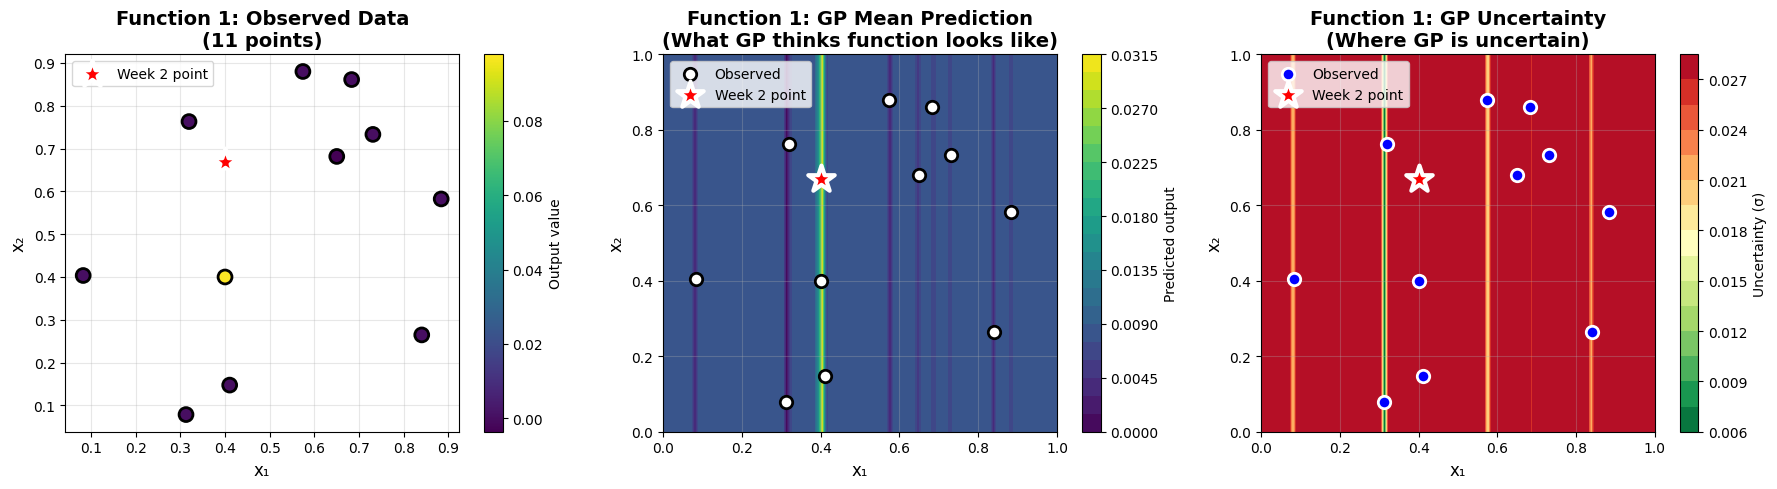


Function 1 Visualization Summary
Current best: 0.097870 at [0.4 0.4]
Week 2 point: [0.40017385 0.66874308]
GP prediction at Week 2 point: 0.097519 ± 0.002485



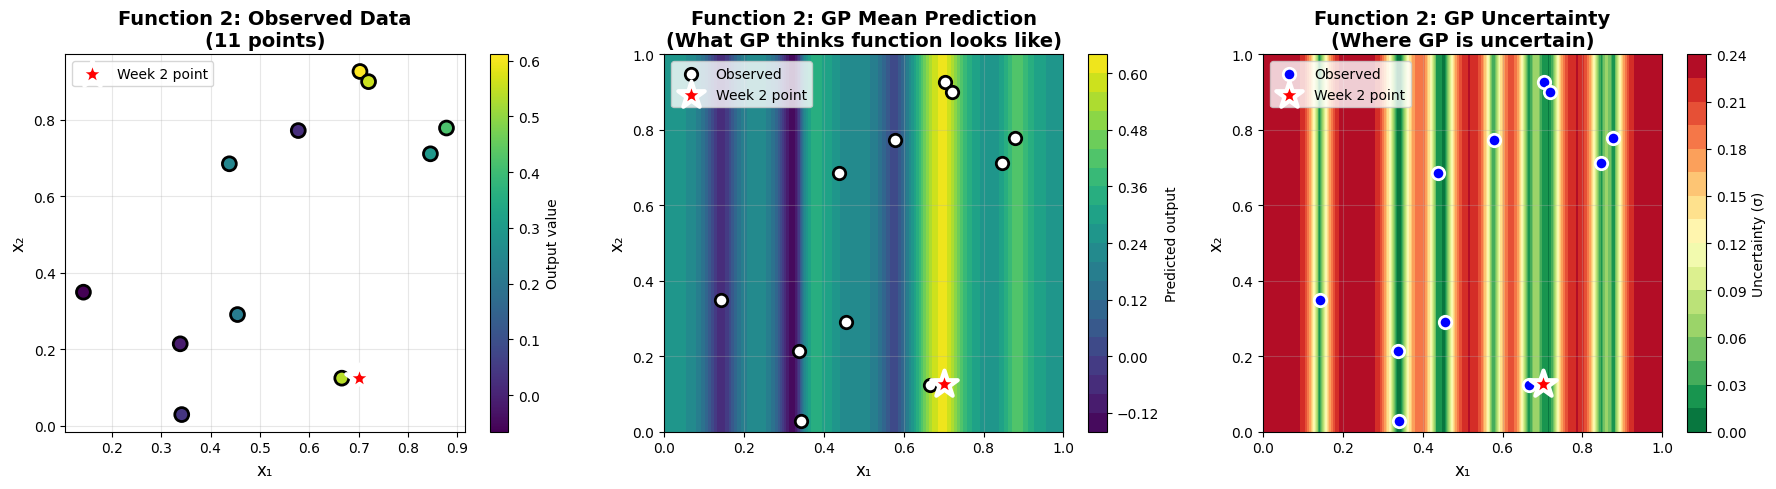


Function 2 Visualization Summary
Current best: 0.611205 at [0.70263656 0.9265642 ]
Week 2 point: [0.70007346 0.12536221]
GP prediction at Week 2 point: 0.613260 ± 0.012709


Key insights:
- Left plot: Your actual data points
- Middle plot: What the GP learned - shows predicted function surface
- Right plot: Uncertainty map - red = high uncertainty, green = low uncertainty
- Red star: Week 2 recommended point

Generating visualizations for Functions 3-8 (Higher Dimensional)...
PCA Projection: Shows data distribution in reduced 2D space
Predicted vs Actual: Validates GP model quality



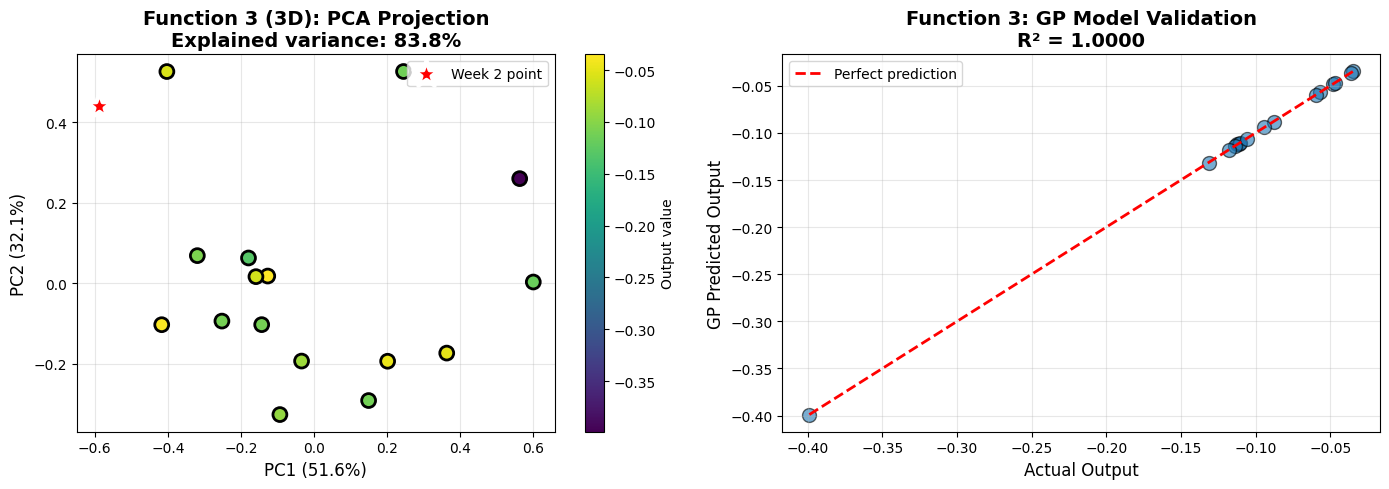


Function 3 (3D) Summary
Data points: 16
Current best: -0.034835
GP R² score: 1.0000 (Excellent fit)
PCA variance explained: 83.8%
Week 2 point prediction: -0.079190 ± 0.084767



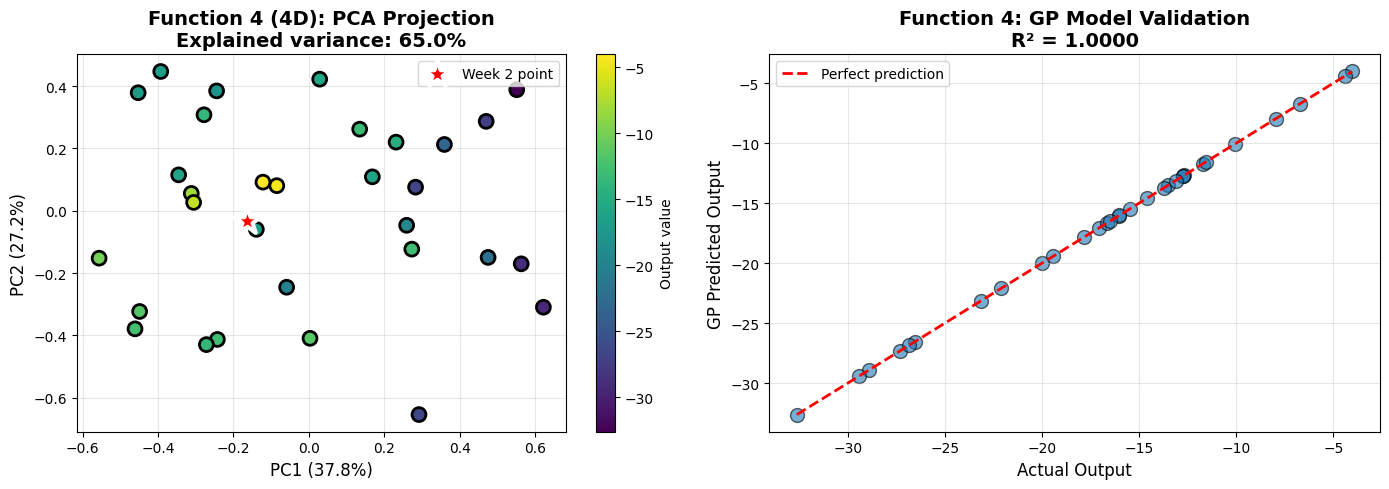


Function 4 (4D) Summary
Data points: 31
Current best: -4.025542
GP R² score: 1.0000 (Excellent fit)
PCA variance explained: 65.0%
Week 2 point prediction: -1.727925 ± 0.712411



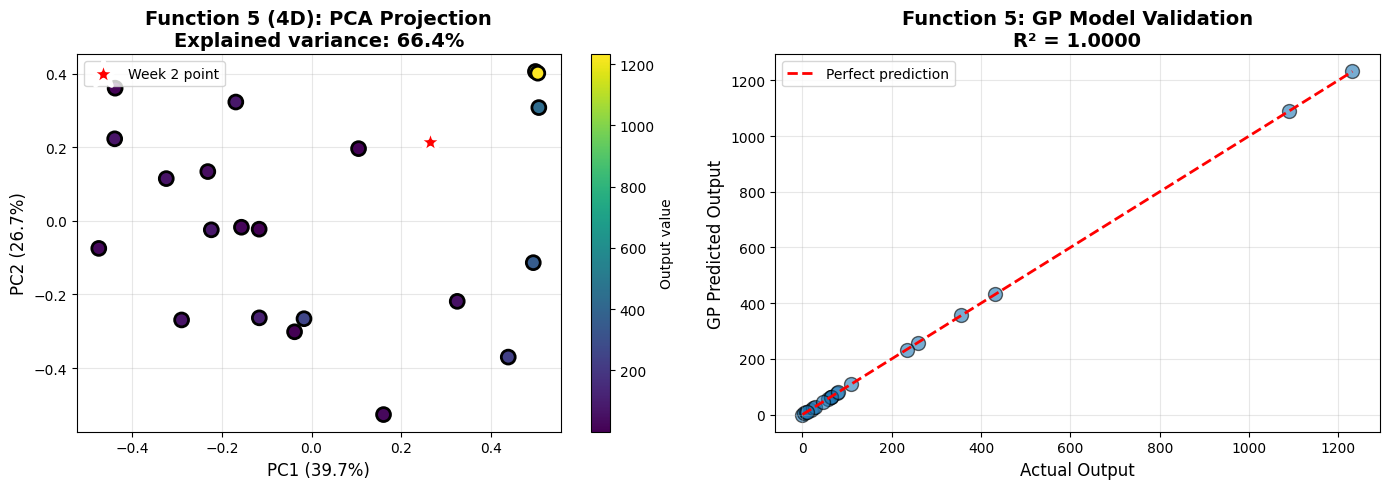


Function 5 (4D) Summary
Data points: 21
Current best: 1231.606836
GP R² score: 1.0000 (Excellent fit)
PCA variance explained: 66.4%
Week 2 point prediction: 829.401788 ± 107.033952



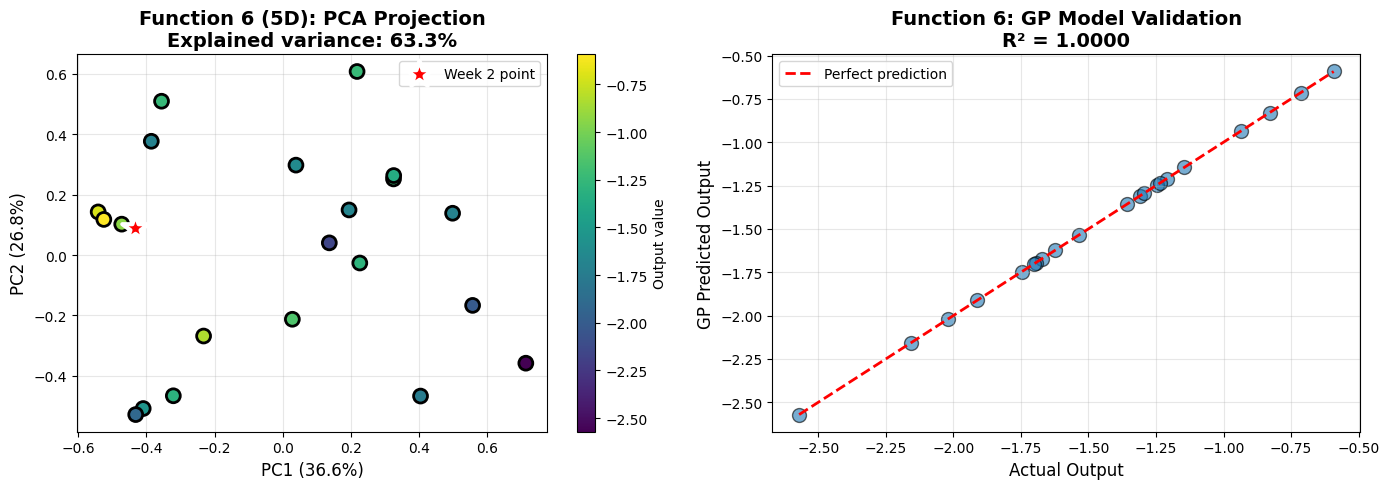


Function 6 (5D) Summary
Data points: 21
Current best: -0.591979
GP R² score: 1.0000 (Excellent fit)
PCA variance explained: 63.3%
Week 2 point prediction: -0.412137 ± 0.168583



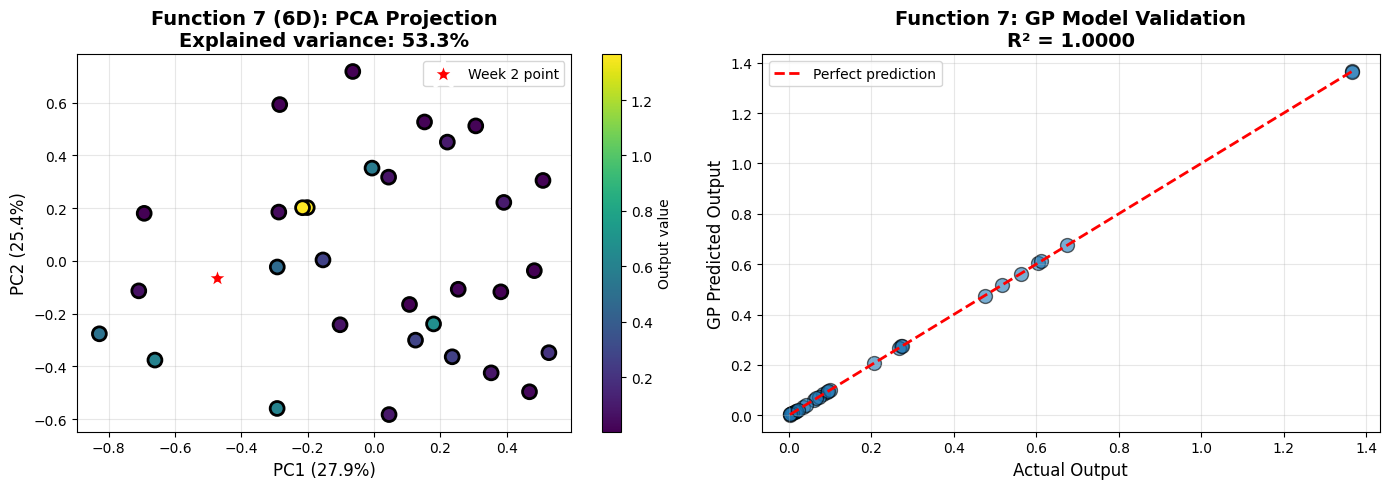


Function 7 (6D) Summary
Data points: 31
Current best: 1.364968
GP R² score: 1.0000 (Excellent fit)
PCA variance explained: 53.3%
Week 2 point prediction: 1.376757 ± 0.072613



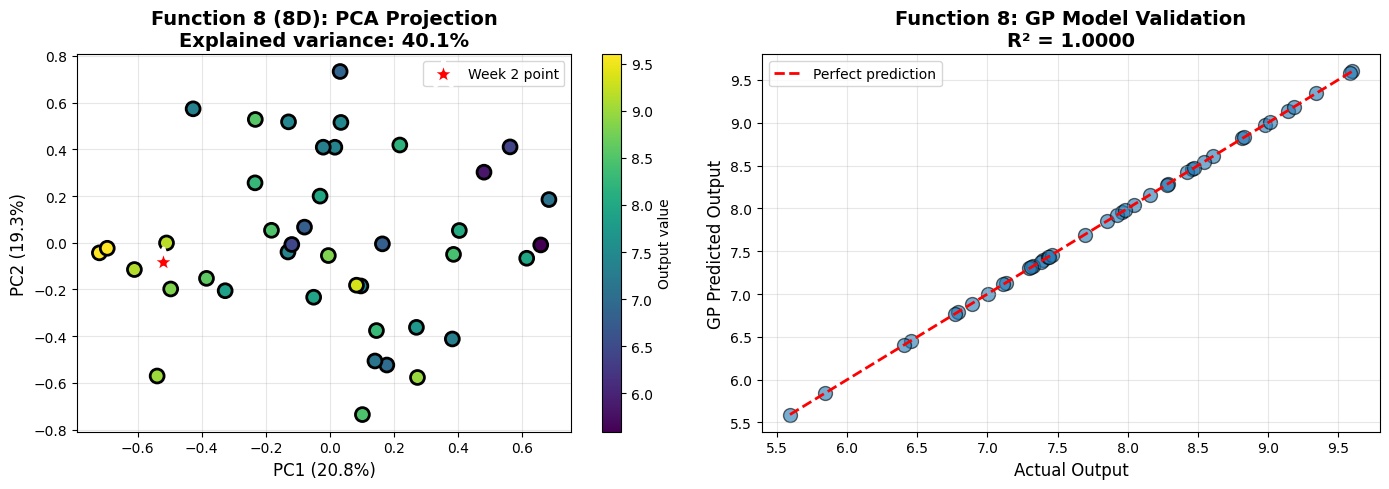


Function 8 (8D) Summary
Data points: 41
Current best: 9.598482
GP R² score: 1.0000 (Excellent fit)
PCA variance explained: 40.1%
Week 2 point prediction: 10.124693 ± 0.233549


Summary of Visualizations:
Functions 1-2: Full GP landscape (mean, uncertainty)
Functions 3-8: PCA projection + GP validation

Key Takeaways:
- Points near diagonal in 'Predicted vs Actual' = GP learned well
- R² > 0.9 = Excellent model fit
- PCA shows overall data distribution (though it loses dimensional info)
- Red stars show where Week 2 will sample next


In [32]:
def visualize_gp_2d(func_id, X_sample, y_sample, next_point, resolution=100):
    """
    Visualize GP predictions and next recommended point for 2D functions

    Args:
        func_id: Function number (1 or 2)
        X_sample: Observed input points (n_samples, 2)
        y_sample: Observed output values (n_samples,)
        next_point: Next recommended point (2,)
        resolution: Grid resolution for contour plots
    """
    if X_sample.shape[1] != 2:
        print(f"Function {func_id} is {X_sample.shape[1]}D - skipping visualization")
        return

    # Fit Gaussian Process
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(2), nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
    gp.fit(X_sample, y_sample)

    # Create mesh grid
    x1 = np.linspace(0, 1, resolution)
    x2 = np.linspace(0, 1, resolution)
    X1, X2 = np.meshgrid(x1, x2)
    X_grid = np.column_stack([X1.ravel(), X2.ravel()])

    # Predict on grid
    y_pred, sigma = gp.predict(X_grid, return_std=True)
    y_pred = y_pred.reshape(X1.shape)
    sigma = sigma.reshape(X1.shape)

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Observed data
    ax = axes[0]
    scatter = ax.scatter(X_sample[:, 0], X_sample[:, 1], c=y_sample, s=100, cmap='viridis',
                        edgecolors='black', linewidths=2, zorder=5)
    ax.scatter(next_point[0], next_point[1], c='red', s=400, marker='*',
              edgecolors='white', linewidths=3, label='Week 2 point', zorder=10)
    plt.colorbar(scatter, ax=ax, label='Output value')
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(f'Function {func_id}: Observed Data\n({len(X_sample)} points)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # Plot 2: GP mean prediction
    ax = axes[1]
    contour = ax.contourf(X1, X2, y_pred, levels=20, cmap='viridis')
    ax.scatter(X_sample[:, 0], X_sample[:, 1], c='white', s=80,
              edgecolors='black', linewidths=2, label='Observed', zorder=5)
    ax.scatter(next_point[0], next_point[1], c='red', s=400, marker='*',
              edgecolors='white', linewidths=3, label='Week 2 point', zorder=10)
    plt.colorbar(contour, ax=ax, label='Predicted output')
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(f'Function {func_id}: GP Mean Prediction\n(What GP thinks function looks like)',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # Plot 3: GP uncertainty
    ax = axes[2]
    contour = ax.contourf(X1, X2, sigma, levels=20, cmap='RdYlGn_r')
    ax.scatter(X_sample[:, 0], X_sample[:, 1], c='blue', s=80,
              edgecolors='white', linewidths=2, label='Observed', zorder=5)
    ax.scatter(next_point[0], next_point[1], c='red', s=400, marker='*',
              edgecolors='white', linewidths=3, label='Week 2 point', zorder=10)
    plt.colorbar(contour, ax=ax, label='Uncertainty (σ)')
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(f'Function {func_id}: GP Uncertainty\n(Where GP is uncertain)',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{'='*70}")
    print(f"Function {func_id} Visualization Summary")
    print(f"{'='*70}")
    print(f"Current best: {np.max(y_sample):.6f} at {X_sample[np.argmax(y_sample)]}")
    print(f"Week 2 point: {next_point}")
    print(f"GP prediction at Week 2 point: {gp.predict(next_point.reshape(1, -1))[0]:.6f} ± {gp.predict(next_point.reshape(1, -1), return_std=True)[1][0]:.6f}")
    print(f"{'='*70}\n")


# Visualize Functions 1 and 2
print("Generating visualizations for Functions 1 and 2...")
print("This shows how the Gaussian Process learned the function landscape\n")

for func_id in [1, 2]:
    X = inputs[func_id]
    y = outputs[func_id]
    next_pt = week2_recommendations[func_id]

    visualize_gp_2d(func_id, X, y, next_pt, resolution=100)

print("\nKey insights:")
print("- Left plot: Your actual data points")
print("- Middle plot: What the GP learned - shows predicted function surface")
print("- Right plot: Uncertainty map - red = high uncertainty, green = low uncertainty")
print("- Red star: Week 2 recommended point")


# ============================================================================
# Visualizations for Functions 3-8 (Higher Dimensional)
# ============================================================================

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

def visualize_high_dim(func_id, X_sample, y_sample, next_point):
    """
    Visualize higher-dimensional functions using PCA and GP validation

    Args:
        func_id: Function number (3-8)
        X_sample: Observed input points
        y_sample: Observed output values
        next_point: Next recommended point
    """
    dim = X_sample.shape[1]

    # Fit Gaussian Process
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(dim), nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
    gp.fit(X_sample, y_sample)

    # Get GP predictions for all points
    y_pred = gp.predict(X_sample)
    r2 = r2_score(y_sample, y_pred)

    # PCA projection to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sample)
    next_point_pca = pca.transform(next_point.reshape(1, -1))

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: PCA projection
    ax = axes[0]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, s=100, cmap='viridis',
                        edgecolors='black', linewidths=2, zorder=5)
    ax.scatter(next_point_pca[0, 0], next_point_pca[0, 1], c='red', s=400, marker='*',
              edgecolors='white', linewidths=3, label='Week 2 point', zorder=10)
    plt.colorbar(scatter, ax=ax, label='Output value')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    ax.set_title(f'Function {func_id} ({dim}D): PCA Projection\n' +
                f'Explained variance: {sum(pca.explained_variance_ratio_)*100:.1f}%',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # Plot 2: Predicted vs Actual
    ax = axes[1]
    ax.scatter(y_sample, y_pred, s=100, alpha=0.6, edgecolors='black', linewidths=1)

    # Perfect prediction line
    min_val = min(y_sample.min(), y_pred.min())
    max_val = max(y_sample.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')

    ax.set_xlabel('Actual Output', fontsize=12)
    ax.set_ylabel('GP Predicted Output', fontsize=12)
    ax.set_title(f'Function {func_id}: GP Model Validation\nR² = {r2:.4f}',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{'='*70}")
    print(f"Function {func_id} ({dim}D) Summary")
    print(f"{'='*70}")
    print(f"Data points: {len(X_sample)}")
    print(f"Current best: {np.max(y_sample):.6f}")
    print(f"GP R² score: {r2:.4f} {'(Excellent fit)' if r2 > 0.9 else '(Good fit)' if r2 > 0.7 else '(Needs more data)'}")
    print(f"PCA variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")
    next_pred = gp.predict(next_point.reshape(1, -1))[0]
    next_std = gp.predict(next_point.reshape(1, -1), return_std=True)[1][0]
    print(f"Week 2 point prediction: {next_pred:.6f} ± {next_std:.6f}")
    print(f"{'='*70}\n")


# Visualize Functions 3-8
print("\n" + "="*70)
print("Generating visualizations for Functions 3-8 (Higher Dimensional)...")
print("="*70)
print("PCA Projection: Shows data distribution in reduced 2D space")
print("Predicted vs Actual: Validates GP model quality\n")

for func_id in range(3, 9):
    X = inputs[func_id]
    y = outputs[func_id]
    next_pt = week2_recommendations[func_id]

    visualize_high_dim(func_id, X, y, next_pt)

print("\n" + "="*70)
print("Summary of Visualizations:")
print("="*70)
print("Functions 1-2: Full GP landscape (mean, uncertainty)")
print("Functions 3-8: PCA projection + GP validation")
print("\nKey Takeaways:")
print("- Points near diagonal in 'Predicted vs Actual' = GP learned well")
print("- R² > 0.9 = Excellent model fit")
print("- PCA shows overall data distribution (though it loses dimensional info)")
print("- Red stars show where Week 2 will sample next")
print("="*70)


## AFTER WEEK 2 RESULTS: Prepare Data for Week 3

**Run this section after you receive Week 2 results to create week3_clean_data.npz**